# Decompose HSC observed QSO image

This notebook requires standard python libraries and the publicly available packages on github:
See https://github.com/dartoon/galight/blob/master/requirements.txt

This notebook has been tested with galight == 0.1.6

For more information, please contact me: dingxuheng@126.com

This notebook is very similar to the 'galight_HST_QSO.ipynb', only that the noise_map, PSF are input to the fittings. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits

#Data is available at: https://drive.google.com/file/d/1ZO9-HzV8K60ijYWK98jGoSoZHjIGW5Lc/view?usp=sharing
fitsFile = pyfits.open('../example_files/HSC/QSO/000017.88+002612.6_HSC-I.fits')

#Load the fov image data:
fov_image = fitsFile[1].data # check the back grounp

#Derive the header informaion, might be used to obtain the pixel scale and the exposure time.
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']

#Derive the fov noise level map:
err_data= fitsFile[3].data ** 0.5

#Calculate the zeropoint for HSC filters:
file_header0 = fitsFile[0].header
FLUXMAG0 = file_header0['FLUXMAG0']
zp =  2.5 * np.log10(FLUXMAG0)   # This is something Xuheng can't make sure.

#Load the PSF data:
PSF = pyfits.getdata('../example_files/HSC/QSO/000017.88+002612.6_HSC-I_psf.fits')

Estimating the background light ... ... ...
Plot target cut out zoom in:


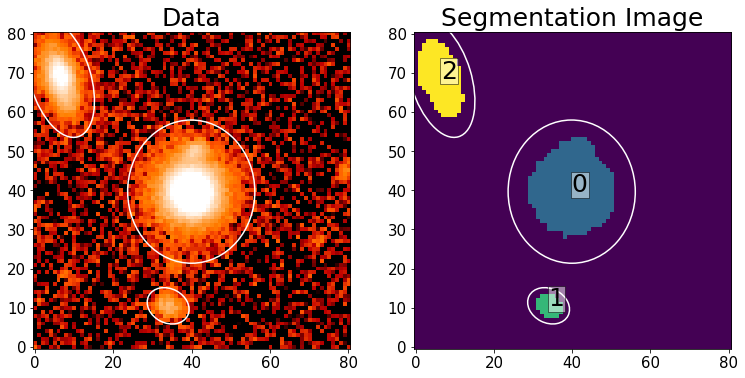

label     xcentroid          ycentroid      ...     kron_flux      kron_fluxerr
                                            ...                                
----- ------------------ ------------------ ... ------------------ ------------
    2  33.97233640859878 10.483390376980072 ... 23.189933440707634          nan
    1 39.878512652743495  39.65420140516439 ...  935.9413749959695          nan
    3 6.4403712688177945  68.56712756371142 ... 162.45549646159748          nan


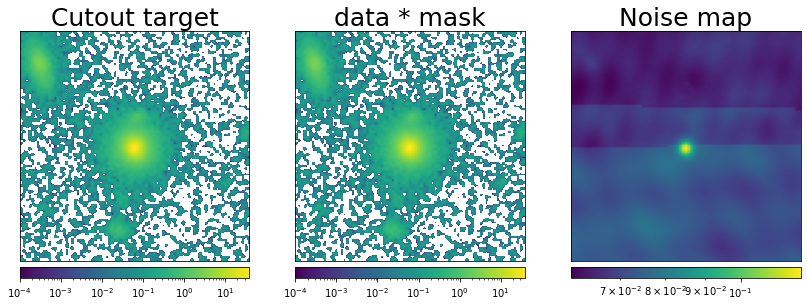

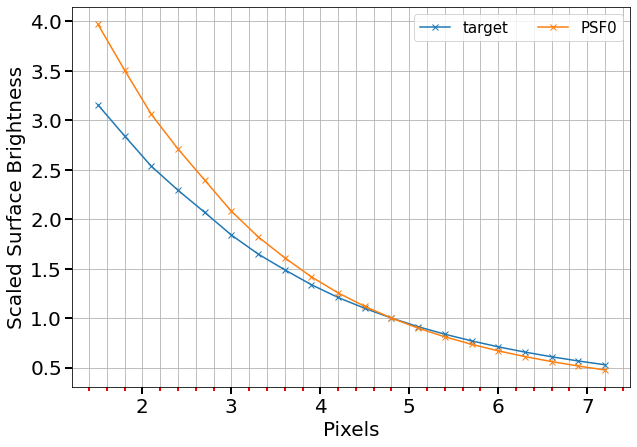

The PSF is not a box size, will cut it to a box size automatically.
The data_process is ready to go to pass to FittingSpecify!


In [2]:
from galight.data_process import DataProcess

#RA, DEC information of the QSO:
QSO_RA, QSO_DEC = 0.07452999800443649, 0.4368380010128021
data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [QSO_RA, QSO_DEC],
                           pos_type = 'wcs', header = header,
                          rm_bkglight = True, if_plot=False, zp = zp)

#Generate the fitting materials
data_process.generate_target_materials(radius=None, create_mask = False, nsigma=2.8, #if_select_obj=True,
                                      exp_sz= 1.5, npixels = 15, if_plot=True)

#Manually input the PSF:
data_process.PSF_list = [PSF]

# Compare the 1D profile of all the components.
data_process.profiles_compare(norm_pix = 5, if_annuli=False, y_log = False,
                  prf_name_list = (['target'] + ['PSF{0}'.format(i) for i in range(len(data_process.PSF_list))]) )


#Check if all the materials is given, if so to pass to the next step.
data_process.checkout() #Check if all the materials is known.

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


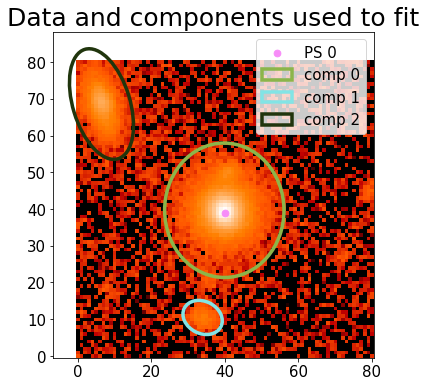

In [3]:
#Start to produce the class and params for lens fitting.
#For more details, see notebook galight_HST_QSO.ipynb
from galight.fitting_specify import FittingSpecify
fit_sepc = FittingSpecify(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 1)
#Using following line: want to fix Sersic_n as 4 for the source_id = 0, and if want to fix the QSO and host center:
# fit_sepc.prepare_fitting_seq(point_source_num = 1, fix_n_list= [[0,4]], fix_center_list = [[0,0]])

#Plot the initial settings for fittings. 
fit_sepc.plot_fitting_sets()

fit_sepc.build_fitting_seq()

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-1.8728189910367365 reduced X^2 of best position
-6121.308872203574 logL
6537.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 2.983225006982236, 'n_sersic': 8.932616010304354, 'e1': -0.08789595102240022, 'e2': 0.0916068660253455, 'center_x': 0.024151938961671674, 'center_y': -0.0911684926980514}, {'amp': 1, 'R_sersic': 0.7702142913407497, 'n_sersic': 1.9792689022774825, 'e1': -0.2636373523673126, 'e2': 0.15157103306331443, 'center_x': 0.8767689125369154, 'center_y': -5.017476344035202}, {'amp': 1, 'R_sersic': 1.4680783009051608, 'n_sersic': 3.475357488301513, 'e1': -0.42296610023239606, 'e2': 0.2832826323387577, 'center_x': 5.655015630782866, 'center_y': 4.888414568323542}] lens light result
[{'ra_image': array([0.02741514]), 'dec_image': array([-0.11617253]), 'point_amp': array([1.])}] point source result
{} special param result
15.361914157867432 time used for  PSO


100%|█████████████████████████████████████████| 130/130 [03:05<00:00,  1.43s/it]


Computing the MCMC...
Number of walkers =  200
Burn-in iterations:  100
Sampling iterations (in current run): 130
187.35188603401184 time taken for MCMC sampling
203.356 total time taken for the overall fitting (s)
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 
Start transfering the Params to fluxs...
6000 MCMC samplers in total, finished translate: 1000
6000 MCMC samplers in total, finished translate: 2000
6000 MCMC samplers in total, finished translate: 3000
6000 MCMC samplers in total, finished translate: 4000
6000 MCMC samplers in total, finished translate: 5000


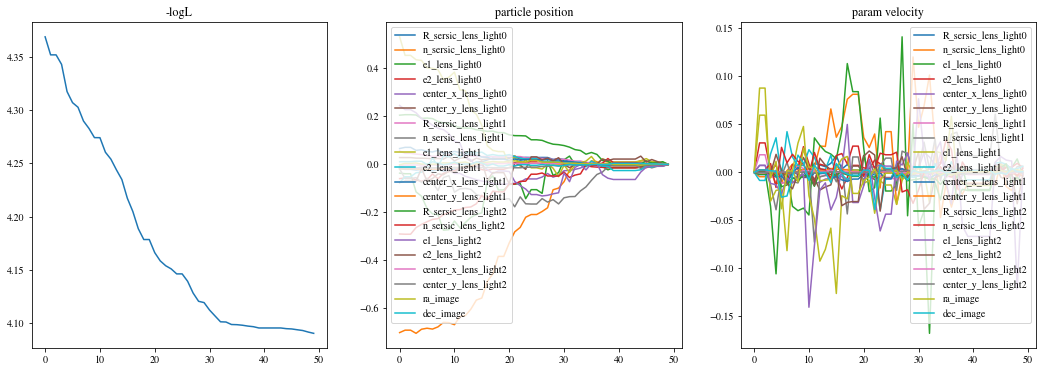

<Figure size 432x288 with 0 Axes>

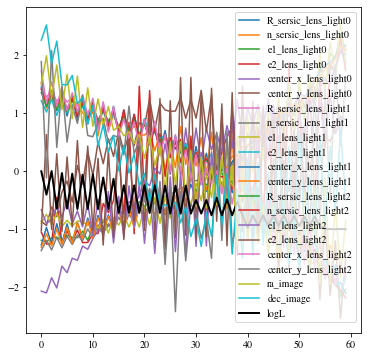

-1.7905082082472252 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  1.7905082082472252


/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:101: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/Users/Dartoon/Astro/Packages/lenstronomy/lenstronomy/Plots/model_band_plot.py:533: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


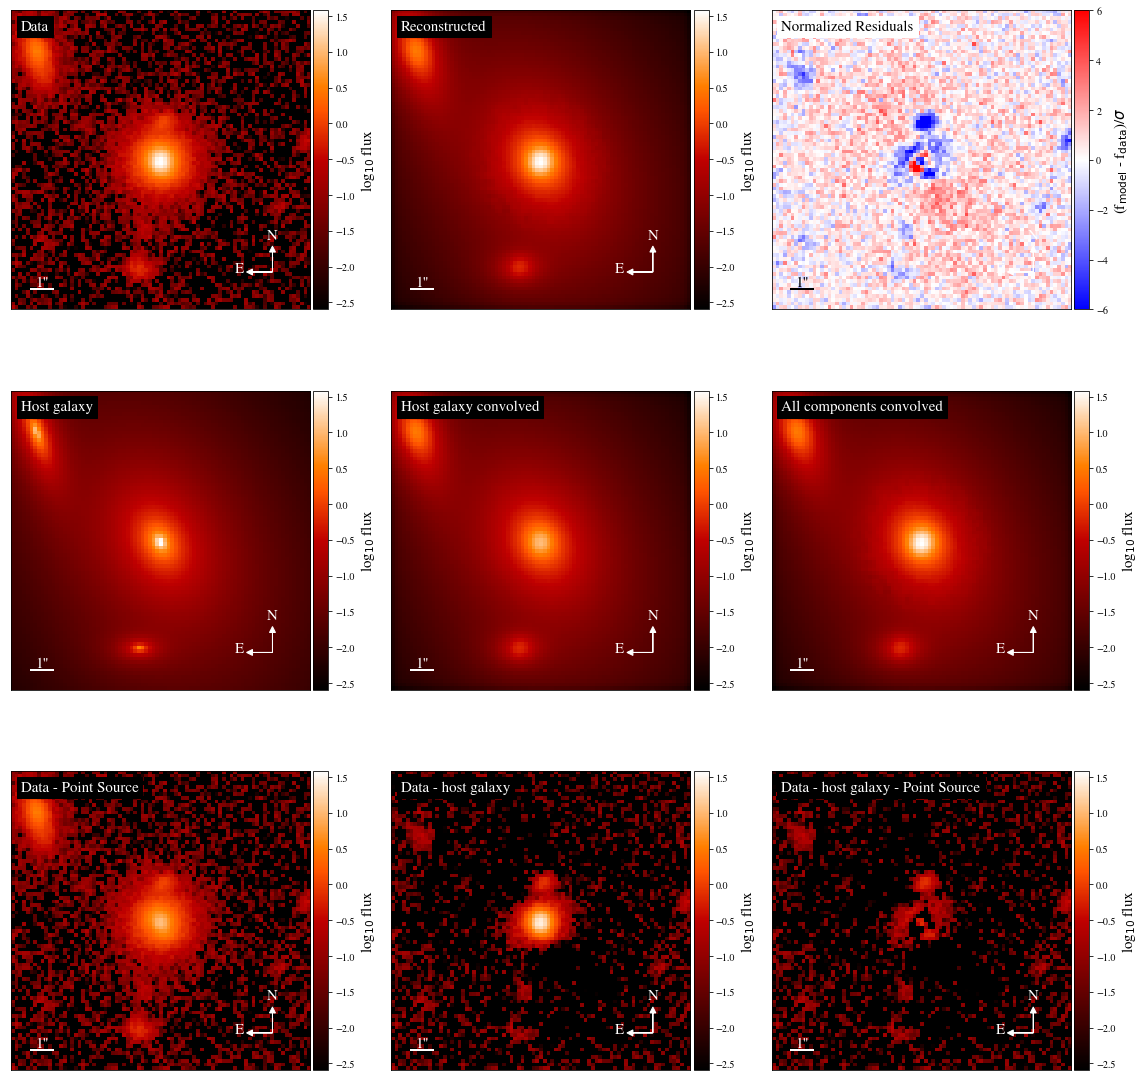

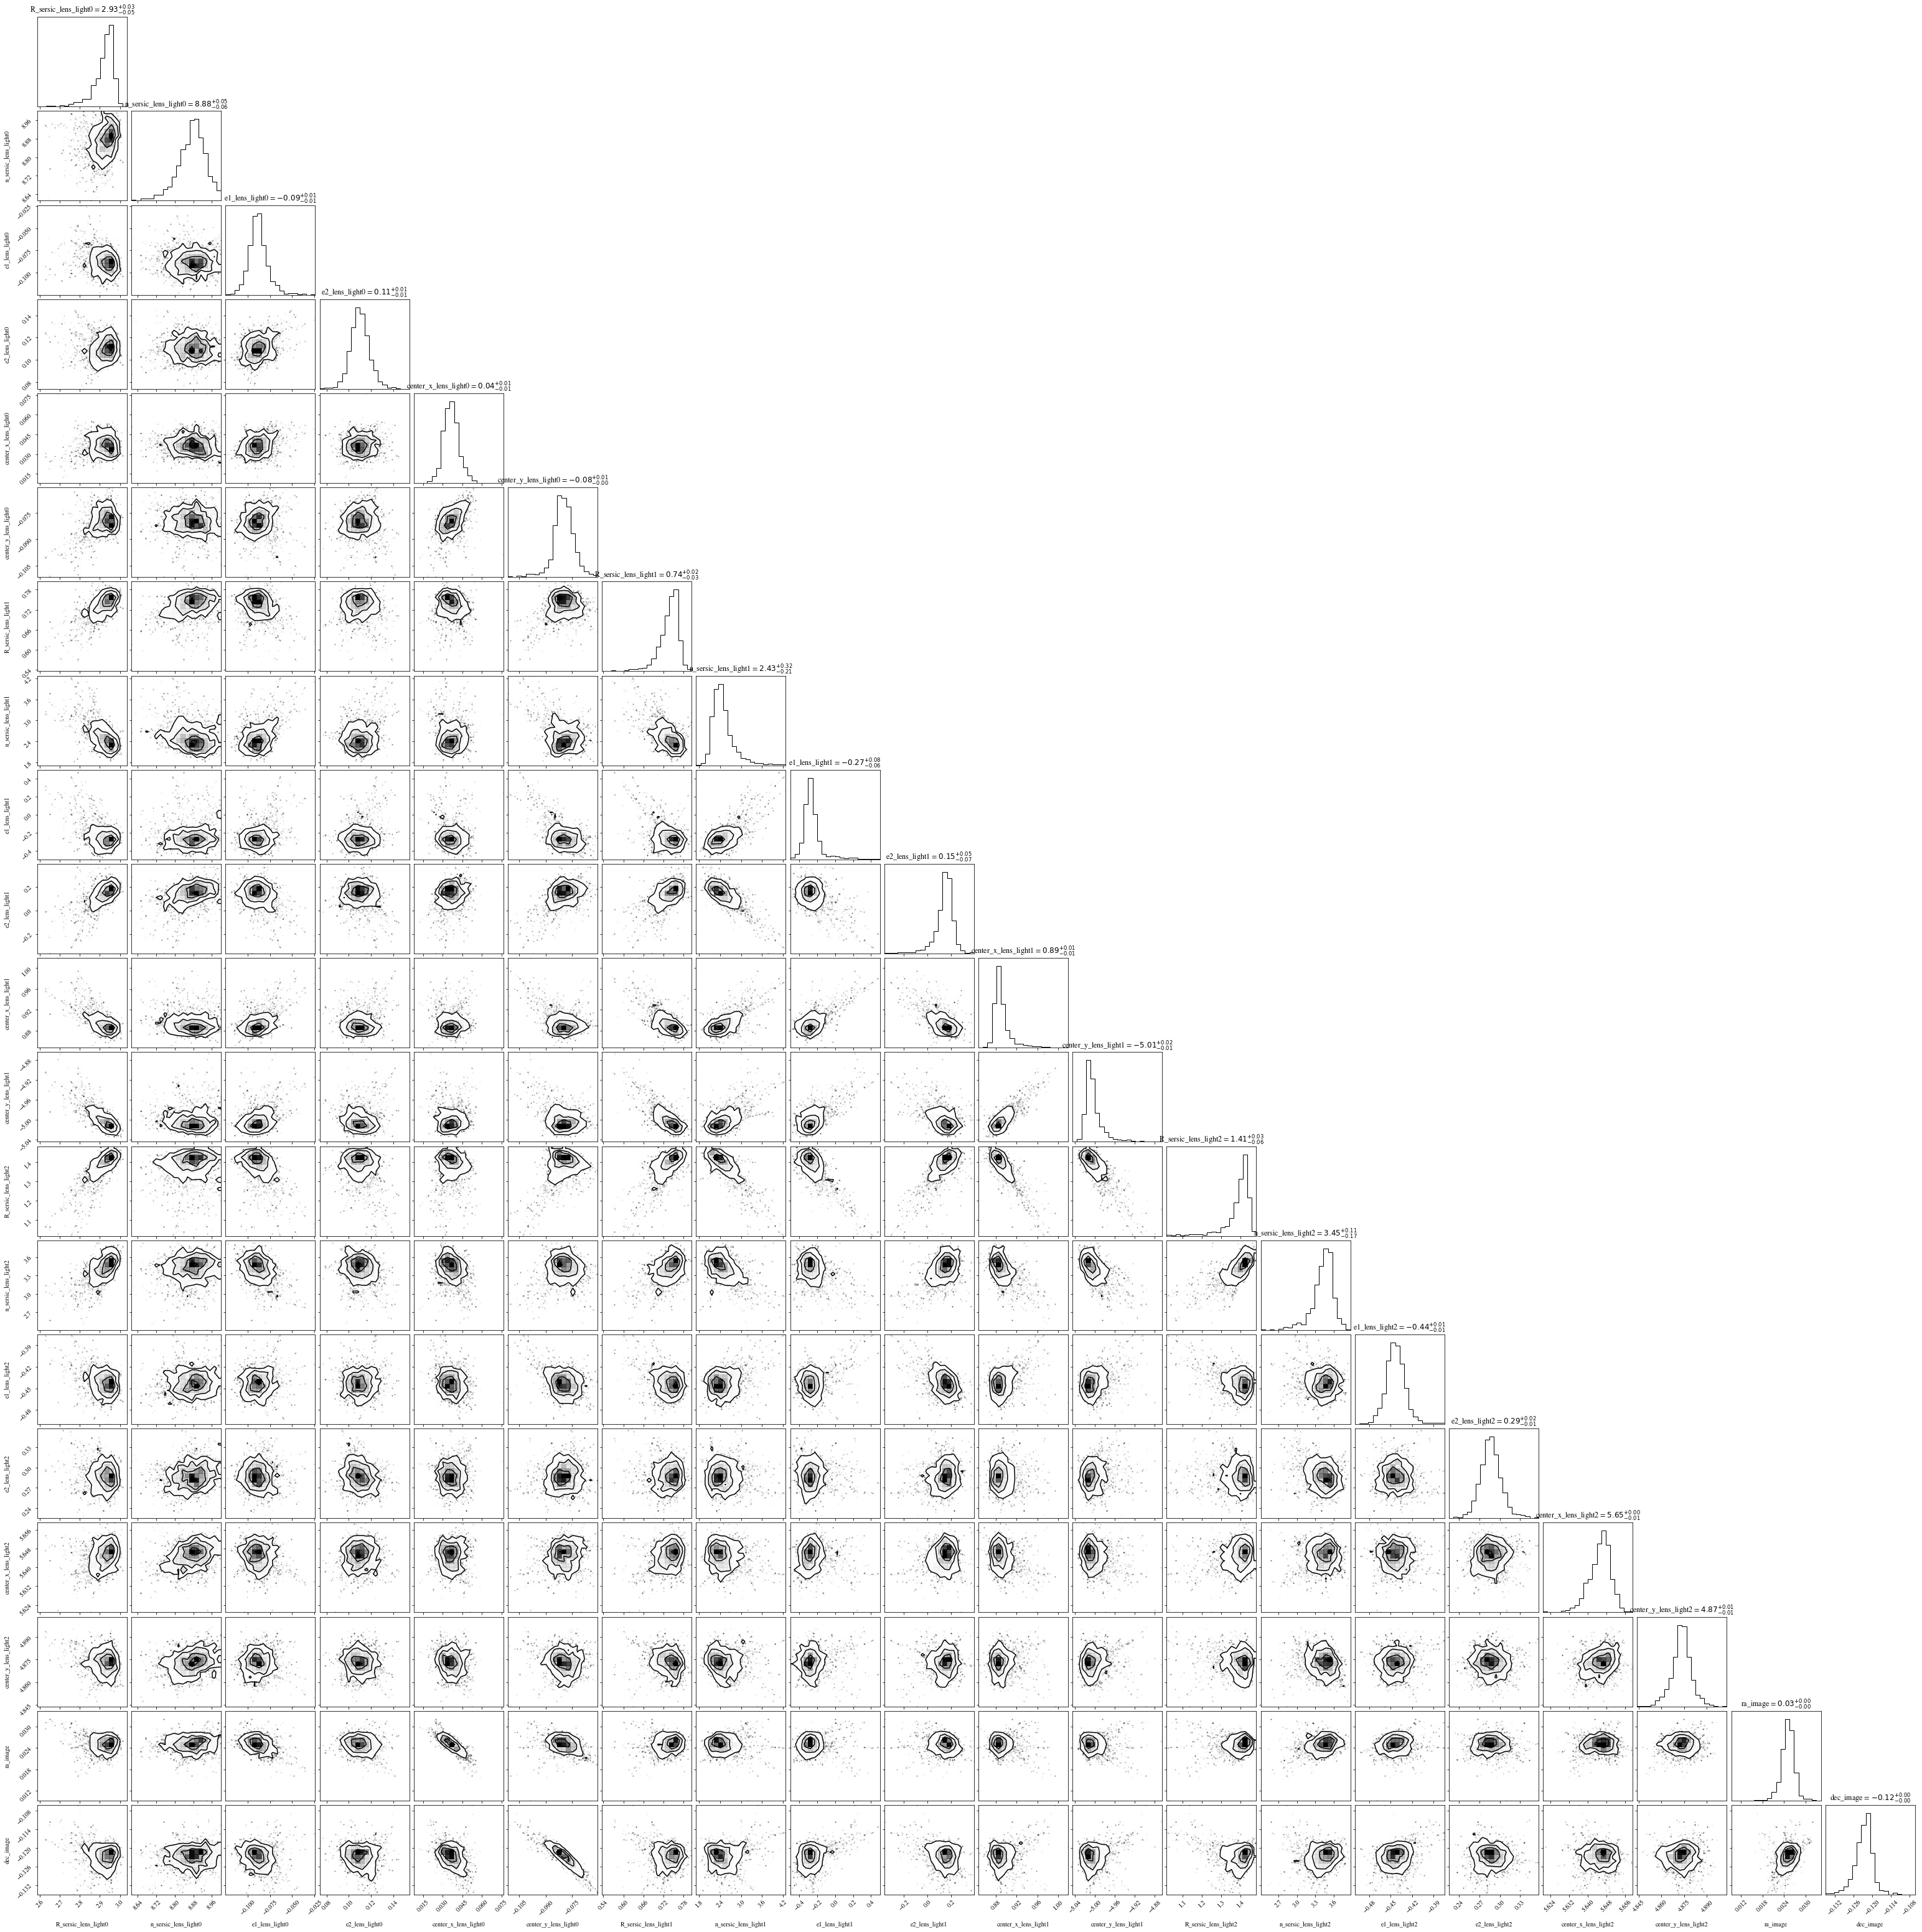

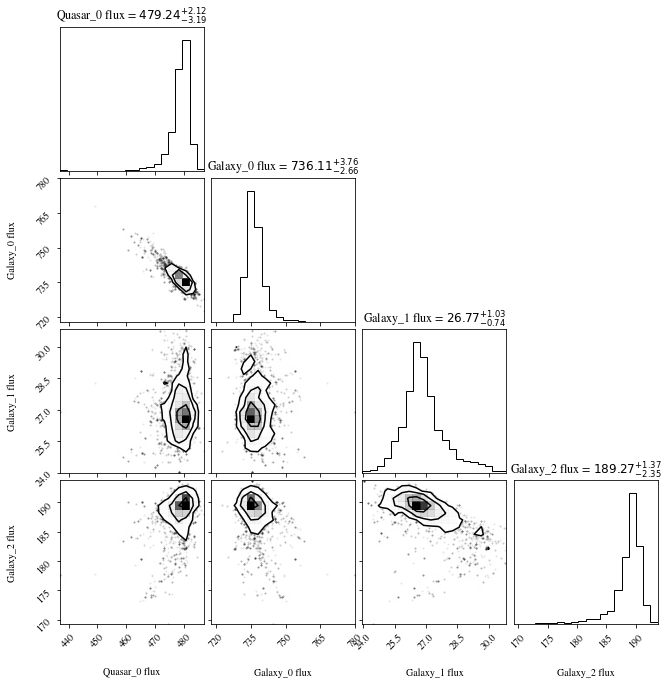

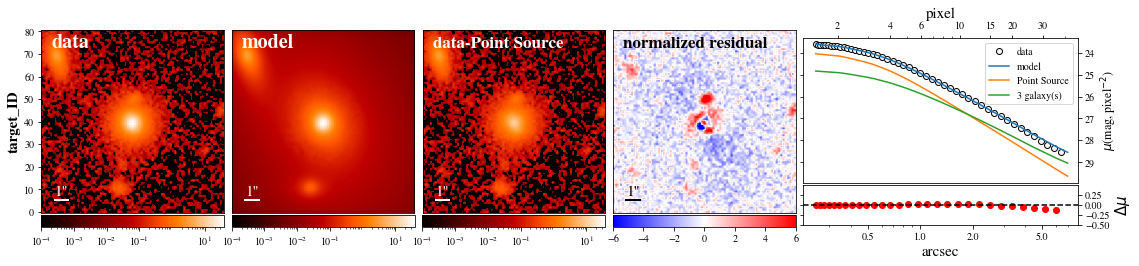

In [4]:
#Setting the fitting method and run.
from galight.fitting_process import FittingProcess

#Pass fit_sepc to FittingProcess,
# savename: The name of the saved files.    
fit_run = FittingProcess(fit_sepc, savename = 'HSC_result', fitting_level='shallow')
#For the fitting_level, you can also put ['shallow', 'deep'] for the later ['PSO', 'MCMC'] corresplingly.

#Setting the fitting approach and Run: 
#     algorithm_list: The fitting approaches that would be used: e.g. ['PSO', 'PSO', 'MCMC']
#     setting_list: The detailed setting for the fitting can be as follows.
#     -for PSO:
#         input template: {'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}
#     -for MCMC:
#         input template: {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}
#     if setting_list = [None, None, None], default values would be given 
fit_run.run(algorithm_list = ['PSO', 'MCMC'], setting_list = [None, None]) 
#Try also setting_list = [{'sigma_scale': 0.8, 'n_particles': 50, 'n_iterations': 50}, {'n_burn': 50, 'n_run': 100, 'walkerRatio': 10, 'sigma_scale': .1}]

# Plot all the fitting results, including:
#         run_diag() : The convergence of the chains.
#         model_plot(): The model plot (by lenstronomy)
#         plot_params_corner(): The mcmc corner for all the chains (MCMC should be peformed) 
#         plot_flux_corner(): The flux corner for all the component (MCMC should be peformed)
#         plot_final_qso_fit() or plot_final_galaxy_fit(): Plot the overall plot (data, model, data-ps, resudal, 1D profile)
fit_run.plot_all()


#Save the fitting class as pickle format:
#     Note, if you use python3 (or 2), load with python3 (or 2)
fit_run.dump_result(savedata=False)  #You can set savedata= True to save the data_process_class, otherwise, it will be removed in pickle.

In [5]:
#Load the saved fitting class, the fitting_run_result would be the loaded as fit_run() in previous fittings.
import pickle
picklename = 'HSC_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))  #fitting_run_result is actually the fit_run in previous box.
#fitting_run_result.plot_final_qso_fit()
fitting_run_result.final_result_galaxy

[{'amp': 6.205369480523229,
  'R_sersic': 2.629531374498916,
  'n_sersic': 8.937705926612166,
  'e1': -0.09305623315805345,
  'e2': 0.12442866338623697,
  'center_x': 0.030612118415723033,
  'center_y': -0.10003704740209547,
  'phi_G': 1.1064658244983225,
  'q': 0.7310369856235951,
  'flux_sersic_model': 1052.5199152773891,
  'flux_within_frame': 740.9583192758437,
  'magnitude': 19.825515553660406},
 {'amp': 6.549324464138142,
  'R_sersic': 0.6088559724446726,
  'n_sersic': 3.246831273466883,
  'e1': 0.2778159286842642,
  'e2': -0.008046347625650596,
  'center_x': 0.9602137010460348,
  'center_y': -4.90350994467161,
  'phi_G': -0.0144773895935233,
  'q': 0.565027976322734,
  'flux_sersic_model': 28.126263888022383,
  'flux_within_frame': 27.14822682165385,
  'magnitude': 23.41564632740878},
 {'amp': 27.069682328393277,
  'R_sersic': 1.066444731796176,
  'n_sersic': 3.0347617835078715,
  'e1': -0.38266956022574045,
  'e2': 0.29714644296739506,
  'center_x': 5.647348086208742,
  'center

### Galight can help you measure the asymetry of the target using the saved pickle file:

#### see also the following link for more details:
https://github.com/dartoon/galight_notebooks/blob/master/galight_measure_asymmetry_CAS.ipynb

Estimating the background light ... ... ...
Zeropoint value is not provided, use 27.0 to calculate magnitude.


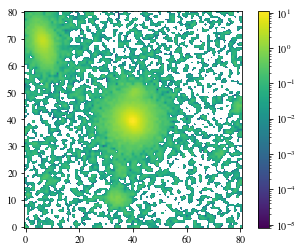

Measuring the position for minimized asy...
Optimization terminated successfully.
         Current function value: 72.929003
         Iterations: 112
         Function evaluations: 219
The pixel position that gives you the minimized asy: [-0.09607541 -0.5       ]


TypeError: cal_asymmetry() got an unexpected keyword argument 'if_remeasure_bkg'

In [6]:
from galight.tools.asymmetry_tools import Measure_asy
from galight.tools.astro_tools import plt_fits
import pickle

picklename = 'HSC_result.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))
if_remeasure_bkg = True

#By default, fit_run.dump_result() will removed the 'data_process_class' to save space. 
#However, the if_remeasure_bkg=True will extend the stamp size using data_process_class,
#so if you want to re-measure bkg, using the following to redefine data_process:
if if_remeasure_bkg == True and hasattr(fitting_run_result.fitting_specify_class, 'data_process_class') == False:
    import astropy.io.fits as pyfits
    from galight.data_process import DataProcess
    QSO_RA, QSO_DEC = 0.07452999800443649, 0.4368380010128021
    fitsFile = pyfits.open('../example_files/HSC/QSO/000017.88+002612.6_HSC-I.fits')
    fov_image = fitsFile[1].data # check the back grounp
    header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']
    err_data= fitsFile[3].data ** 0.5
    data_process = DataProcess(fov_image = fov_image, fov_noise_map = err_data, target_pos = [QSO_RA, QSO_DEC],
                               pos_type = 'wcs', header = header,
                              rm_bkglight = True, if_plot=False, zp = None)
    fitting_run_result.fitting_specify_class.data_process_class = data_process

asy_class = Measure_asy(fitting_run_result, seg_cal_reg = 'or', obj_id=0)  
#in last line, seg_cal_reg='or' means the segm map will be extended. Try also 'and'.
asy_class.img -= asy_class.fitting_process_class.image_ps_list[0]  #Point source will be removed first.

plt_fits(asy_class.img,colorbar=True)
asy_class.asy_segm(mask_type='segm')  #Try also mask_type='aper'
pos = asy_class.find_pos()
print('The pixel position that gives you the minimized asy:', pos["x"])
asy = asy_class.cal_asymmetry(rotate_pix = pos["x"], if_remeasure_bkg=if_remeasure_bkg, 
                              if_plot=True, if_plot_bkg=True)
print('asymmetry :', asy)